# DL-based Stock Price Prediction Notebook
Starting with an LSTM-based predictor, inspired by https://github.com/jinglescode/time-series-forecasting-pytorch/tree/main (also on https://www.alphavantage.co/stock-prediction-deep-neural-networks-lstm/)

In [56]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Literal
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [ ]:
ROOT = Path().resolve().parent
DATA = ROOT / "data"
DAILY_PRICES = DATA / "daily_trading_prices"
MINUTELY_PRICES = DATA / "minutely_trading_prices"

HISTORICAL_PRICES = DAILY_PRICES / "20250505 14_56_24 ^GDAXI Close price data 1987-12-30 to 2025-05-05.csv"

## LSTM Development

### Data Loading

In [ ]:
price_column = 'Close'
date_column = 'Datetime'

price_file = pd.read_csv(HISTORICAL_PRICES)
price_file.dropna(axis=0, inplace=True)
price_file[date_column] = pd.to_datetime(price_file[date_column])
price_file[price_column] = price_file[price_column].astype(float) 

price_series = price_file.set_index(date_column)[price_column]
price_series

In [ ]:
price_series.plot(ylabel='Price [€]', title='Historical DAX Price Development', figsize=(10, 6))
plt.grid()

### Data Preparation

#### Normalisation
Scaling the data is important for convergence during model training. We utilise the *normalisation* technique.

In [ ]:
class Normaliser():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        """ Normalise an array of values. """
        self.mu = np.mean(x, axis=0)
        self.sd = np.std(x, axis=0)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        """ Reverse-transform an array of normalised values. """
        return (x*self.sd) + self.mu

In [ ]:
normalised_price_series = Normaliser().fit_transform(price_series)
normalised_price_series

#### Training Data
Split a share of the data (with the most recent datapoints) for model validation.

In [ ]:
validation_split = 0.2
rolling_window_size = 20
sampling_rate = 'day'

In [76]:
normalised_price_series

Datetime
1987-12-30   -1.256058
1988-01-04   -1.266210
1988-01-05   -1.257953
1988-01-06   -1.255887
1988-01-07   -1.254123
                ...   
2025-04-28    3.177085
2025-04-29    3.209221
2025-04-30    3.224053
2025-05-02    3.346973
2025-05-05    3.387347
Name: Close, Length: 9441, dtype: float64

In [77]:
X = normalised_price_series.to_numpy()

# this converts each single price value of X into an array of values containing 20 retrospective prices:
np.lib.stride_tricks.as_strided(X, shape=(len(X)-rolling_window_size+1, rolling_window_size), strides=(X.strides[0], X.strides[0]))[:-1]

array([[-1.25605768, -1.26620953, -1.25795256, ..., -1.26375599,
        -1.26554664, -1.27011393],
       [-1.26620953, -1.25795256, -1.25588675, ..., -1.26554664,
        -1.27011393, -1.27048081],
       [-1.25795256, -1.25588675, -1.25412321, ..., -1.27011393,
        -1.27048081, -1.26724973],
       ...,
       [ 3.15453434,  3.23301629,  3.20192691, ...,  3.17099388,
         3.17708513,  3.20922087],
       [ 3.23301629,  3.20192691,  3.06154183, ...,  3.17708513,
         3.20922087,  3.22405265],
       [ 3.20192691,  3.06154183,  2.8373111 , ...,  3.20922087,
         3.22405265,  3.34697337]], shape=(9421, 20))

Using last 20.0% of data for validation. Other data for training.


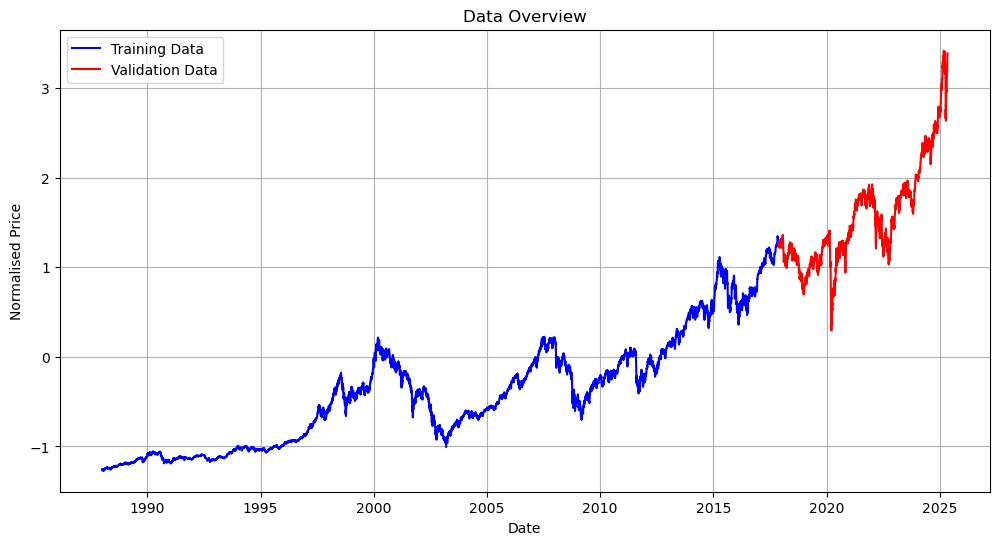

In [63]:

# window X values:

# split prices into training and validation data:
print(f"Using last {100 * validation_split}% of data for validation. Other data for training.")
validation_split_index = int(len(normalised_price_series) * (1-validation_split))
X_train = normalised_price_series.iloc[:validation_split_index]
X_val = normalised_price_series.iloc[validation_split_index:]
# target values start after rolling window:
Y_train = normalised_price_series.iloc[rolling_window_size:rolling_window_size+validation_split_index]
Y_val = normalised_price_series.iloc[rolling_window_size+validation_split_index:]

# plot result:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(X_train, label='Training Data', color='blue')
ax.plot(X_val, label='Validation Data', color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Normalised Price')
ax.set_title('Data Overview')
ax.grid(True)
ax.legend()

### Define LSTM Model

In [65]:
from typing import Union

class TimeSeriesDataset(Dataset):
    def __init__(self,
                 X: Union[pd.DataFrame, pd.Series, np.ndarray],
                 Y: Union[pd.Series, pd.Series, np.ndarray]):
        # convert values to numpy if necessary:
        if isinstance(X, (pd.Series, pd.DataFrame)):
            X = X.to_numpy()
        if isinstance(Y, (pd.Series, pd.DataFrame)):
            Y = Y.to_numpy()
            
        # expand tensor for LSTM input:
        X = np.expand_dims(X, 2)
        
        # save values:
        self.X = X.astype(np.float32)
        self.Y = Y.astype(np.float32)
        
    # necessary operators:
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [73]:
np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))

Rolling [window=20,center=False,axis=0,method=single]

In [71]:
X_train.to_numpy().

array([-1.25605768, -1.26620953, -1.25795256, ...,  1.25418556,
        1.24303536,  1.2565704 ], shape=(7552,))

In [66]:
dataset_train = TimeSeriesDataset(X_train, Y_train)
dataset_val = TimeSeriesDataset(X_val, Y_val)

AxisError: axis 2 is out of bounds for array of dimension 2

In [ ]:
Y_val